Plot results from an offline evaluation of the main ML model. This notebook depends on offline diagnostics computed by the `train-evaluate-prognostic-run` workflow.

Figure 2, Figure S1 and Figure S2 are generated by this notebook.

In [1]:
import xarray as xr
import fsspec
import fv3viz
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from textwrap import wrap
matplotlib.rcParams['figure.dpi'] = 200

In [2]:
url = 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/rf-control/offline_diags-redo-v2/offline_diagnostics.nc'
COORD_NAMES = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
}
COORD_VARS = {
    "lonb": ["y_interface", "x_interface", "tile"],
    "latb": ["y_interface", "x_interface", "tile"],
    "lon": ["y", "x", "tile"],
    "lat": ["y", "x", "tile"],
}

In [3]:
def global_mean(da, weights, dims=["x", "y", "tile"]):
    gm = (da*weights).sum(dims) / weights.sum(dims)
    return gm.assign_attrs(da.attrs)

In [4]:
with fsspec.open(url) as f:
    ds = xr.open_dataset(f).load()

### Compute R2 skill

In [5]:
for variable in ['dQ1', 'dQ2', 'dQu', 'dQv']:
    sum_squares = ds[f'zonal_avg_pressure_level-mse-{variable}-predict_vs_target']
    mean_sum_squares = ds[f'zonal_avg_pressure_level-mse-{variable}-mean_vs_target']
    ds[f'zonal_avg_pressure_level-r2-{variable}-predict_vs_target'] = 1 - sum_squares / mean_sum_squares

### Better attributes and units

In [6]:
ds['column_integrated_dQ1'] = ds['column_integrated_dQ1'].assign_attrs(long_name='Column heating', units='W/m$^2$')
ds['column_integrated_dQ2'] = ds['column_integrated_dQ2'].assign_attrs(long_name='Column moistening', units='mm/day')
ds['column_integrated_dQu'] = ds['column_integrated_dQu'].assign_attrs(long_name='Column eastward\nwind tendency', units='Pa')
ds['column_integrated_dQv'] = ds['column_integrated_dQv'].assign_attrs(long_name='Column northward\nwind tendency', units='Pa')

for variable, pretty in zip(['dQ1', 'dQ2', 'dQu', 'dQv'], ['Q_1', 'Q_2', 'Q_u', 'Q_v']):
    ds[f'zonal_avg_pressure_level-r2-{variable}-predict_vs_target'].attrs['long_name'] = f'R$^2$ of $\Delta {pretty}$ prediction'

ds['pressure'] = ds['pressure'] / 100
ds['pressure'].attrs['units'] = 'hPa'

ds = ds.rename(lat_interp='latitude')
ds['latitude'].attrs['units'] = '$^{\circ}$N'

### Figure 2: target and predicted dQ1 and dQ2

/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


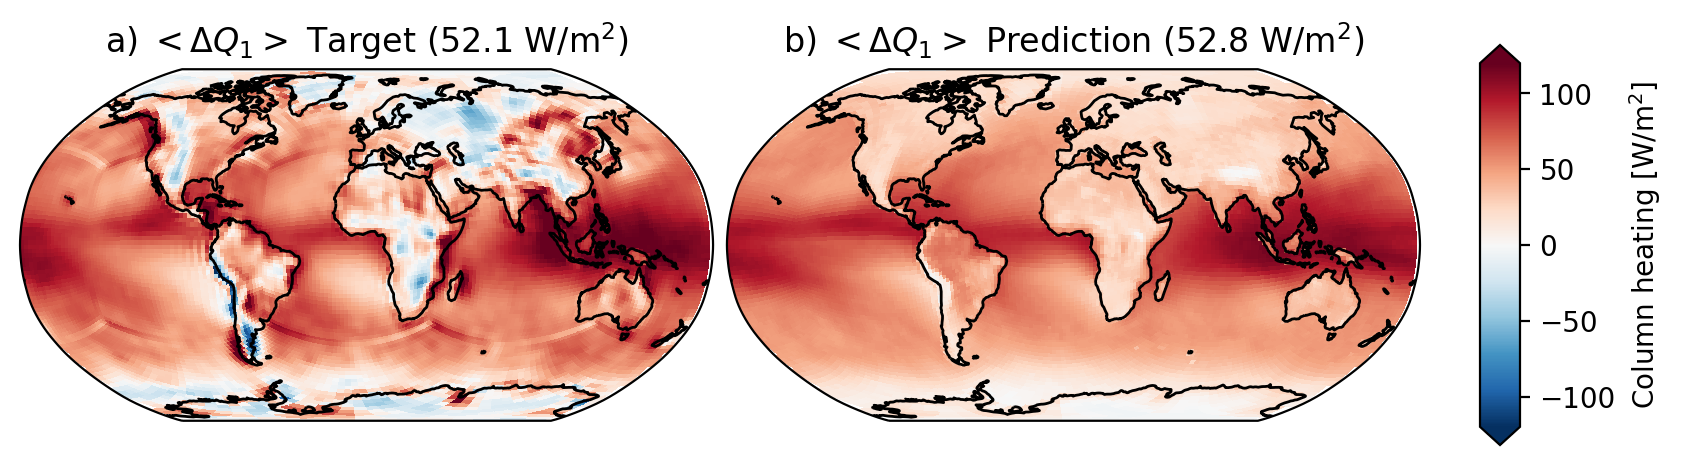

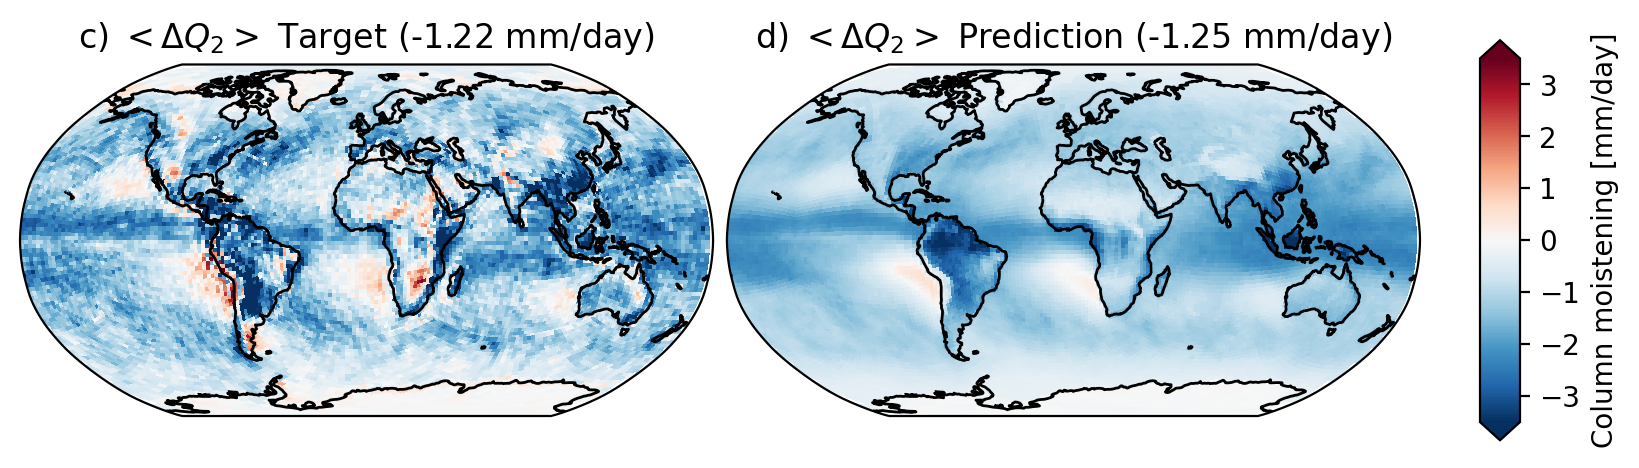

In [7]:
plot_kwargs = {
    'column_integrated_dQ1': {'vmin': -120, 'vmax': 120},
    'column_integrated_dQ2': {'vmin': -3.5, 'vmax': 3.5},
}
titles = {
    'column_integrated_dQ1': ['a) $<\Delta Q_1>$ Target', 'b) $<\Delta Q_1>$ Prediction'],
    'column_integrated_dQ2': ['c) $<\Delta Q_2>$ Target', 'd) $<\Delta Q_2>$ Prediction'],
}
for variable in ['column_integrated_dQ1', 'column_integrated_dQ2']:
    gm = global_mean(ds[variable], ds.area)
    mv = fv3viz.mappable_var(ds, variable, coord_vars=COORD_VARS, **COORD_NAMES)
    fg = fv3viz.plot_cube(mv, col='derivation', **plot_kwargs[variable])[-1]
    fg.fig.set_size_inches(10, 2.5)
    for i in range(2):
        fg.axes.flat[i].set_title(f'{titles[variable][i]} ({gm.values[i]:.3} {gm.units})')

### Figure S1: target and predicted dQu and dQv

/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


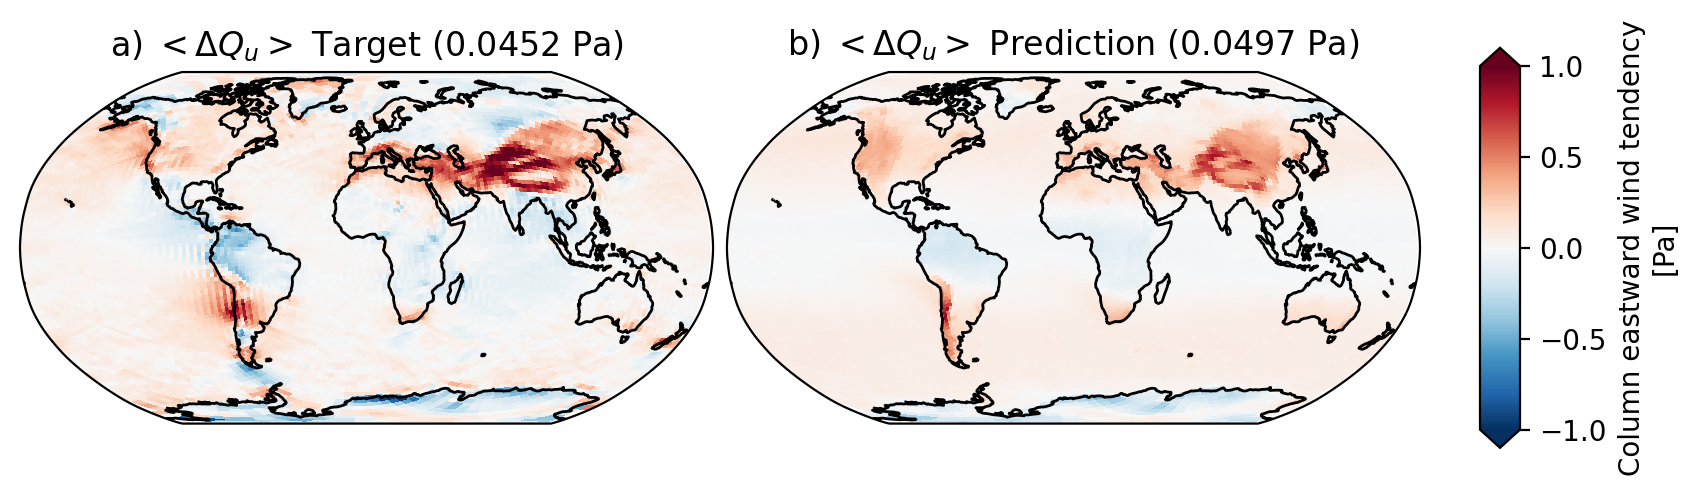

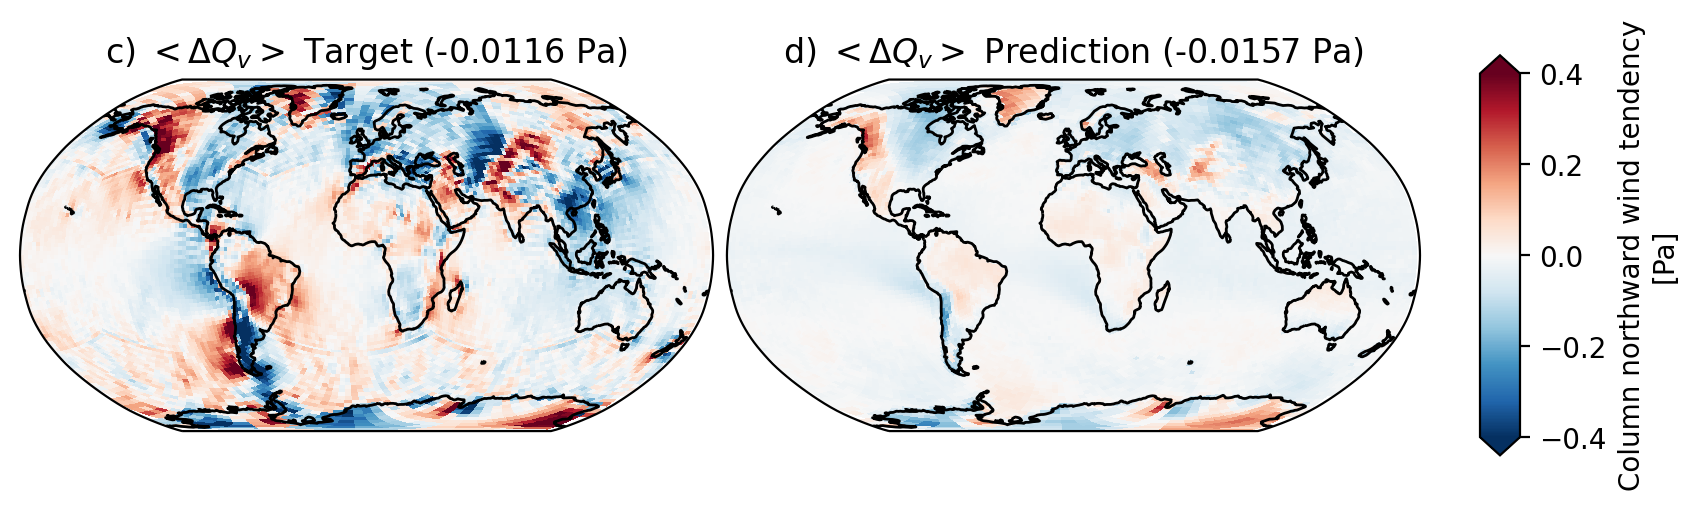

In [8]:
plot_kwargs = {
    'column_integrated_dQu': {'vmin': -1, 'vmax': 1},
    'column_integrated_dQv': {'vmin': -0.4, 'vmax': 0.4},
}
titles = {
    'column_integrated_dQu': ['a) $<\Delta Q_u>$ Target', 'b) $<\Delta Q_u>$ Prediction'],
    'column_integrated_dQv': ['c) $<\Delta Q_v>$ Target', 'd) $<\Delta Q_v>$ Prediction'],
}
for variable in ['column_integrated_dQu', 'column_integrated_dQv']:
    gm = global_mean(ds[variable], ds.area)
    mv = fv3viz.mappable_var(ds, variable, coord_vars=COORD_VARS, **COORD_NAMES)
    fg = fv3viz.plot_cube(mv, col='derivation', **plot_kwargs[variable])[-1]
    fg.fig.set_size_inches(10, 2.5)
    for i in range(2):
        fg.axes.flat[i].set_title(f'{titles[variable][i]} ({gm.values[i]:.3} {gm.units})')

### Figure S2: Plot zonal mean R$^2$ skill

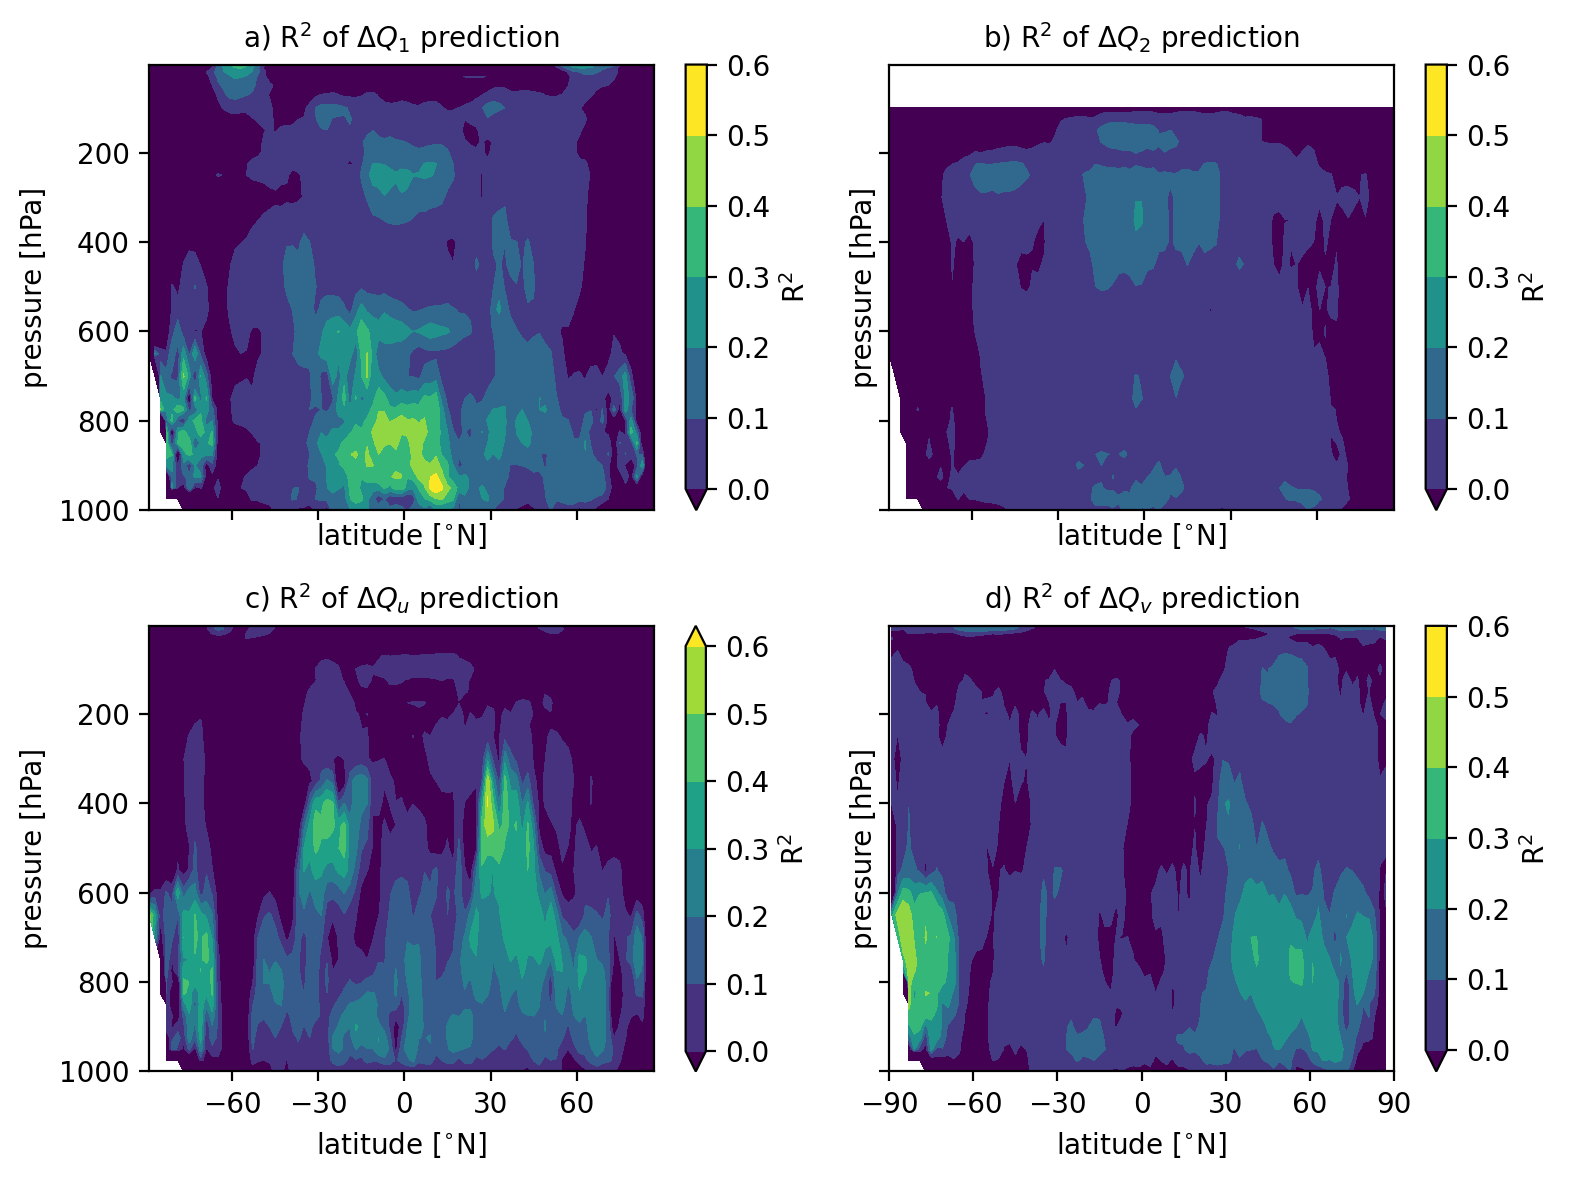

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
variables = [f'zonal_avg_pressure_level-r2-{x}-predict_vs_target' for x in ['dQ1', 'dQ2', 'dQu', 'dQv']]
letter = ['a', 'b', 'c', 'd']
for i, variable in enumerate(variables):
    da = ds[variable].rename('R$^2$').copy()
    long_name = da.long_name
    del da.attrs['long_name']
    da.plot.contourf(ax=axes.flat[i], y='pressure', yincrease=False, vmin=0, vmax=0.6)
    axes.flat[i].set_title(f'{letter[i]}) {long_name}', fontsize=10)
    axes.flat[i].set_xticks(range(-90, 91, 30))
plt.tight_layout()